In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

## Data Load & Cleaning

In [ ]:
df = pd.read_csv(r"E:\Github Repos\Marketing Campaign ab Testing Project\Marketing Campaign raw dataset.csv")

print(df.shape)

print(df.info())

df.head()

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\Rizwan Hussain\AppData\Local\Temp\ipykernel_3252\1528475906.py:1: SyntaxWarning: invalid escape sequence '\G'
  df = pd.read_csv("E:\Github Repos\Marketing Campaign ab Testing Project\Marketing Campaign raw dataset.csv")


(588101, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB
None


,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [8]:
# df = df.drop(columns=df.columns[0]) # Dropping the first unnamed column
df = df.drop(columns=["Unnamed: 0"]) #or specify the exact name if known
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


### Convert Column Names to snake_case

In [9]:
df.columns = [
    "user_id",
    "test_group",
    "converted",
    "total_ads",
    "most_ads_day",
    "most_ads_hour"
]
# df.head()


### Data Quality Checks

In [10]:
df.isnull().sum()

df.duplicated().sum()

np.int64(0)

### Validate Experiment Structure
- psa -> control group
- ad -> treatment group

In [11]:
df["test_group"].value_counts() # Check the distribution of users in test groups A and B

test_group
ad     564577
psa     23524
Name: count, dtype: int64

In [12]:

df["converted"].value_counts() # Check the distribution of converted and non-converted users

converted
False    573258
True      14843
Name: count, dtype: int64

In [13]:
# Save clean dataset
df.to_csv("marketing_AB_cleaned.csv", index=False)

## Exploratory Data Analysis (EDA)

Now explore the marketing A/B testing dataset to:
- Understand group sizes
- Compare conversion rates
- Analyze ad exposure patterns
- Detect any imbalance or anomalies

In [14]:
# Load clean dataset
df = pd.read_csv("marketing_AB_cleaned.csv")
# df.head()

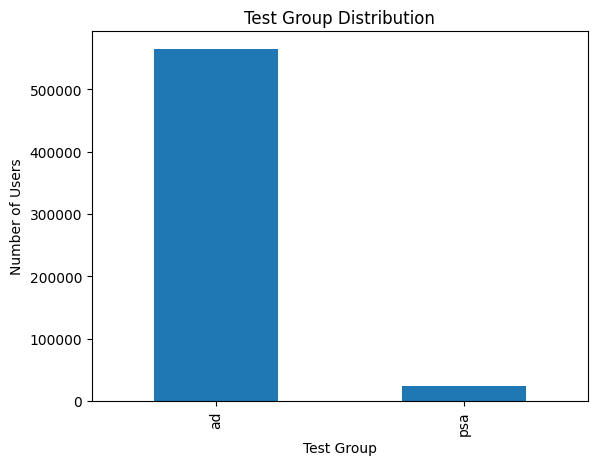

In [15]:
# Group Size Analysis

df["test_group"].value_counts().plot(kind='bar', title='Test Group Distribution')
plt.xlabel('Test Group')
plt.ylabel('Number of Users')
plt.show()

In [16]:
# Conversion Rate Analysis

conversion_summary = df.groupby("test_group")["converted"].agg(
    users="count",
    conversions="sum"
)

conversion_summary["conversion_rate"] = (
    conversion_summary["conversions"] / conversion_summary["users"]
)

conversion_summary 


,users,conversions,conversion_rate
test_group,,,
ad,564577,14423,0.025547
psa,23524,420,0.017854


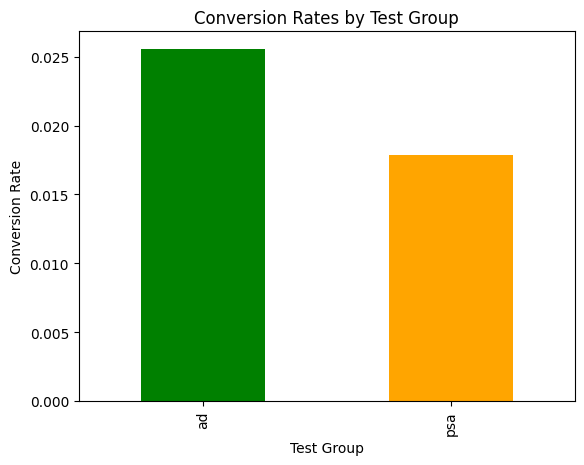

In [17]:
conversion_rates = df.groupby("test_group")["converted"].mean()
conversion_rates.plot(kind='bar', title='Conversion Rates by Test Group', color=['green', 'orange'])
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.show()

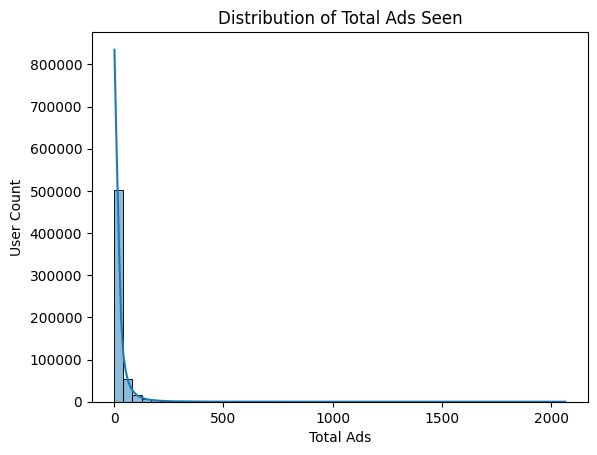

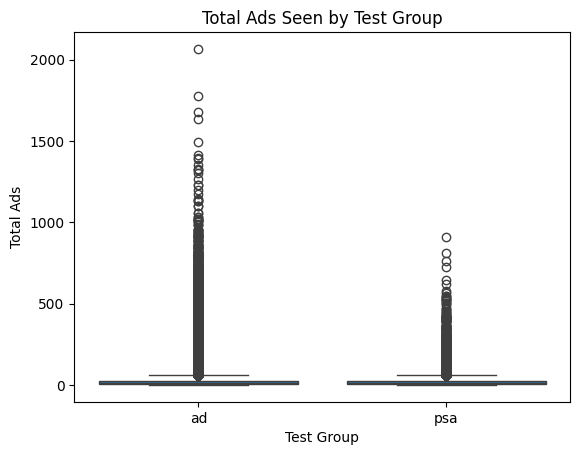

In [18]:
# Ads Exposure Distribution Analysis

sns.histplot(df["total_ads"], bins=50, kde=True)
plt.title("Distribution of Total Ads Seen")
plt.xlabel("Total Ads")
plt.ylabel("User Count")
plt.show()

sns.boxplot(x="test_group", y="total_ads", data=df)
plt.title("Total Ads Seen by Test Group")
plt.xlabel("Test Group")
plt.ylabel("Total Ads")
plt.show()


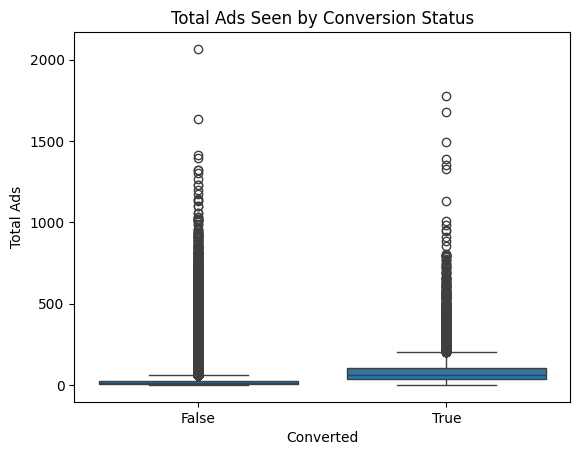

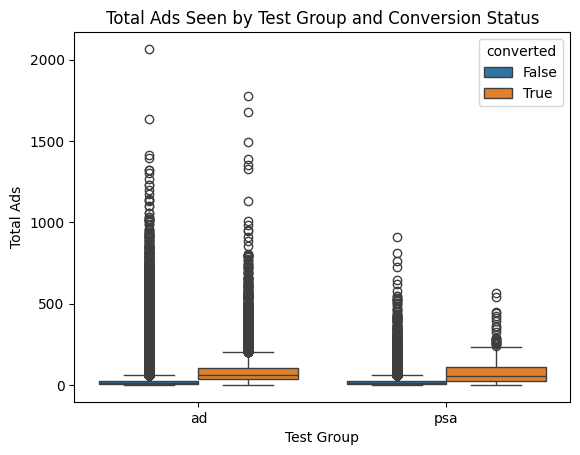

In [19]:
# Ad Exposure vs Conversion 
sns.boxplot(x="converted", y="total_ads", data=df)
plt.title("Total Ads Seen by Conversion Status")
plt.xlabel("Converted")
plt.ylabel("Total Ads")
plt.show()

sns.boxplot(x="test_group", y="total_ads", hue="converted", data=df)
plt.title("Total Ads Seen by Test Group and Conversion Status")
plt.xlabel("Test Group")
plt.ylabel("Total Ads")
plt.show()


## Conversion Rate By Day of Week / Hour of Day

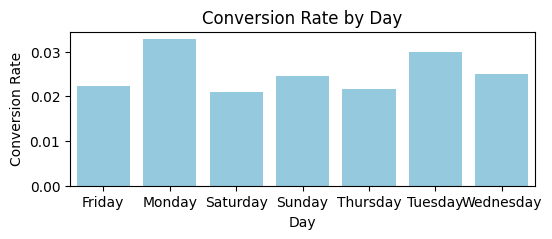

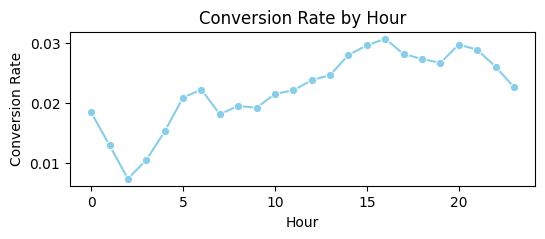

In [32]:
day_summary = (
    df.groupby("most_ads_day")["converted"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(6,2))
sns.barplot(data=day_summary, x="most_ads_day", y="converted", color='skyblue')
plt.title("Conversion Rate by Day")
plt.xlabel("Day")
plt.ylabel("Conversion Rate")
plt.show()

# Conversion Rate by Hour of Day 
hour_summary = (
    df.groupby("most_ads_hour")["converted"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(6,2))
sns.lineplot(data=hour_summary, x="most_ads_hour", y="converted", marker="o", color='skyblue')
plt.title("Conversion Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Conversion Rate")
plt.show()



## Hypothesis Testing using statsmodels

In [21]:
from statsmodels.stats.proportion import proportions_ztest

### Business Problem
Does showing ads to users increase the conversion rate compared to
showing a public service announcement (PSA)?

### Hypotheses

- Null Hypothesis (H₀):
  Conversion rate of Ad group = Conversion rate of PSA group

- Alternative Hypothesis (H₁):
  Conversion rate of Ad group > Conversion rate of PSA group


### Significance Level

We choose a significance level (α) of 0.05.
This means we accept a 5% risk of rejecting the null hypothesis incorrectly.


In [22]:
# summary table for z-test
summary = df.groupby("test_group")["converted"].agg(
    users="count",
    conversions="sum"
)

summary

,users,conversions
test_group,,
ad,564577,14423
psa,23524,420


In [23]:
# Extract Test Inputs
# Conversions
conv_ad = summary.loc["ad", "conversions"] # treatment group
conv_psa = summary.loc["psa", "conversions"] # control group

# Number of users
n_ad = summary.loc["ad", "users"]
n_psa = summary.loc["psa", "users"]

print(f"conv_ad: {conv_ad}, conv_psa: {conv_psa}, n_ad: {n_ad}, n_psa: {n_psa}")


conv_ad: 14423, conv_psa: 420, n_ad: 564577, n_psa: 23524


In [24]:
# Running Proportion Z-Test  -> # statistical test comparing two proportions
'''statistical hypothesis test to determine if showing ads increases conversion rates compared to PSAs.
'''

count = np.array([conv_ad, conv_psa]) # array containing number of conversions in each group
nobs = np.array([n_ad, n_psa]) # array containing total number of users in each group

z_stat, p_value = proportions_ztest( # z_stat: test statistic, p_value: probability value
    count=count,
    nobs=nobs,
    alternative="larger"  # One-sided test checking if ad group has higher conversion rate than PSA group
)

print(f"Z-stat: {z_stat}, P-value: {p_value}")


Z-stat: 7.3700781265454145, P-value: 8.526403580779863e-14


### Statistical Decision Rule

- If p-value < 0.05 → Reject H₀
- If p-value ≥ 0.05 → Fail to reject H₀


In [25]:
# make statistical decision

alpha = 0.05  # significance level

if p_value < alpha:
    decision = "Reject the null hypothesis"
else:
    decision = "Fail to reject the null hypothesis"

decision


'Reject the null hypothesis'

### Conversion Rates and Effect Size

In [26]:
# Conversion Rates

cr_ad = conv_ad / n_ad
cr_psa = conv_psa / n_psa

print(f"Conversion Rate for Ad Group: {cr_ad}\nConversion Rate for PSA Group: {cr_psa}")

Conversion Rate for Ad Group: 0.025546559636683747
Conversion Rate for PSA Group: 0.01785410644448223


In [27]:
# Absolute and Relative Lift -> metrics that quantify the effectiveness of the ad campaign compared to the PSA campaign.

absolute_lift = cr_ad - cr_psa # raw difference in conversion rates btw two groups
relative_lift = (absolute_lift / cr_psa) * 100 # percentage increase in conversion rate relative to PSA group

print(f"Absolute Lift: {absolute_lift}\nRelative Lift: {relative_lift}%")


Absolute Lift: 0.007692453192201517
Relative Lift: 43.085064022225836%


### Final Interpretation

- The p-value tells us whether the difference is statistically significant
- The lift tells us whether the difference is meaningful for the business

Both are required to make a recommendation.


## Business Conclusion

**Statistical Test Results:**
- **Decision**: Reject the null hypothesis ✓
- **Statistical Significance**: Confirmed at α = 0.05 level

**Conversion Performance:**
- **Ad Group Conversion Rate**: 2.55%
- **PSA Group Conversion Rate**: 1.79%

**Business Impact:**
- **Absolute Lift**: 0.77 percentage points
- **Relative Lift**: 43.09%

**Interpretation:**

The A/B test demonstrates that showing ads produces a statistically significant 
**43.09% increase** in conversion rate compared to PSAs. This translates to 
0.77 additional percentage points in conversions.

In practical terms, for every 1,000 users:
- **PSA group** converts ~18 users
- **Ad group** converts ~26 users
- **Net gain**: 8 additional conversions per 1,000 users

**Recommendation:**

Based on the strong statistical evidence and substantial business impact (43% lift), 
i would **strongly recommend rolling out the ad campaign to all users**. This implementation 
is expected to increase overall conversions by approximately 43%, representing a 
significant revenue opportunity for the business.